In [1]:
library(devtools)
devtools::install_github("prodriguezsosa/conText")

Loading required package: usethis




cli          (3.6.0      -> 3.6.1     ) [CRAN]
rlang        (1.0.6      -> 1.1.0     ) [CRAN]
vctrs        (0.5.2      -> 0.6.2     ) [CRAN]
tibble       (3.1.8      -> 3.2.1     ) [CRAN]
pillar       (1.8.1      -> 1.9.0     ) [CRAN]
RcppArmad... (0.12.0.1.0 -> 0.12.2.0.0) [CRAN]
gtable       (0.3.1      -> 0.3.3     ) [CRAN]
dplyr        (1.1.0      -> 1.1.2     ) [CRAN]
ggplot2      (3.4.1      -> 3.4.2     ) [CRAN]
quanteda     (3.2.4      -> 3.3.0     ) [CRAN]


Installing 10 packages: cli, rlang, vctrs, tibble, pillar, RcppArmadillo, gtable, dplyr, ggplot2, quanteda

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘cli’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘rlang’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘vctrs’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘gtable’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘pillar’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘tibble’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘dplyr’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘ggplot2’ had non-zero exit status”


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpzgJLff/remotese43fef420/prodriguezsosa-conText-523f736/DESCRIPTION’ ... OK
* preparing ‘conText’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘conText_1.4.3.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(conText)
library(quanteda)
library(dplyr)
library(text2vec)
library(hunspell)
library(tidyverse)
# library(magrittr)

Package version: 3.3.0
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 4 of 4 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘hunspell’


The following object is masked from ‘package:quanteda’:

    dictionary


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
data <- readRDS("/kaggle/input/twitter-data-top-500-university/tweet_all_blm_test_30Mar23.rds")
data <- data[(data$UniSerial <= 300) & (data$MainHandle == 1), ]

In [4]:
data$AfterBLM <- "No"
data$AfterBLM[data$year <= 2018 ] <- "No"
data$AfterBLM[data$year > 2018 ] <- "Yes"

data$IsTop <- "No"
data$IsTop[data$UniSerial <= 100 ] <- "Yes"
data$IsTop[data$UniSerial > 100 ] <- "No"

In [5]:
data <- data %>% select(Tweet, AfterBLM, IsTop)

In [6]:
print(dim(data))

[1] 3906616       3


In [7]:
# Pre processing 

# tokenize corpus removing unnecessary (i.e. semantically uninformative) elements
corp <- corpus(data, text_field = "Tweet")
gc()

toks <- tokens(corp, 
               remove_punct=T, 
               remove_symbols=T, 
               remove_numbers=T, 
               remove_separators=T, 
               remove_url=T, 
               verbose=F)
gc()

toks_nostop <- tokens_select(toks, 
                             pattern = c(stopwords("en"), "http", "https", "t", "co", "bit", "ly", "thank", "thanks", "you", "amp", "campus", "RT", "pm", "p.m", "am", "a.m",
                                      "prof", "prof.", "professor", "saturday", "sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "w", "w/o", "w/", "mt", "congrats", "congratulations",
                                      "hello", "bye", "welcome", "see", "check", "tomorrow", "today", "tonight", "yesterday", "class", "classes", "break", "vacation", "wish", "wishing", 
                                      "christmas", "xmas", "day", "night", "year", "month", "season", "summar", "winter", "spring", "fall", "session", "sessions", "term",
                                      "student", "students", "can", "cannot", "can't", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero", "ones", "zeros",
                                      "us", "they", "them", "their", "these", "those", "dr", "s", "university", "school", "college", "colleges"), 
                             selection = "remove", 
                             min_nchar=3)
gc()

# only use features that appear at least 5 times in the corpus
feats <- dfm(toks_nostop, 
             tolower=T, 
             verbose = FALSE) %>% dfm_trim(min_termfreq = 5) %>% featnames()
gc()

# leave the pads so that non-adjacent words will not become adjacent
toks_nostop_feats <- tokens_select(toks_nostop, 
                                   feats, 
                                   padding = TRUE)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10877789,581.0,21164450,1130.4,19535572,1043.4
Vcells,105576667,805.5,308386391,2352.9,481606798,3674.4


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,18435520,984.6,39002584,2083.0,39002584,2083.0
Vcells,150541728,1148.6,1061859963,8101.4,1132885155,8643.3


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22342769,1193.3,39002584,2083.0,39002584,2083.0
Vcells,184384986,1406.8,849487971,6481.1,1132885155,8643.3


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22354735,1193.9,39002584,2083.0,39002584,2083.0
Vcells,184622241,1408.6,679590377,5184.9,1132885155,8643.3


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,26261383,1402.6,39002584,2083.0,39002584,2083.0
Vcells,215018697,1640.5,679590377,5184.9,1132885155,8643.3


In [8]:
# 1. Building tokenized corpus
target <- c('black')

# build a tokenized corpus of contexts surrounding the target term
target_toks <- tokens_context(x = toks_nostop_feats, 
                              pattern = target, 
                              window = 6L)
print(head(docvars(target_toks)))

# 2. Build a document-feature-matrix
# build document-feature matrix
target_dfm <- dfm(target_toks)

22783 instances of "black" found.
  pattern AfterBLM IsTop
1   black       No   Yes
2   black       No   Yes
3   black       No   Yes
4   black       No   Yes
5   black       No   Yes
6   black       No   Yes


In [9]:
# 3. Build a document-embedding-matrix

# build a document-embedding-matrix
glove_model = readRDS("/kaggle/input/glovepretrained-embrgrsn/local_glove.rds")
local_transform <- readRDS("/kaggle/input/glovepretrained-embrgrsn/local_transform.rds")

target_dem <- dem(x = target_dfm, 
                 pre_trained = glove_model, 
                 transform = TRUE, 
                 transform_matrix = local_transform, 
                 verbose = TRUE)

# each document inherits its corresponding docvars
print(head(target_dem@docvars))

# you can check which documents were not embedded due to lack of overlapping features (in this example all documents are embedded)
# note: 'quanteda' functions like `docvars()` and `docnames()` don't work on `dem` objects, so you will have to call the attributes directly. 
#setdiff(docnames(immig_dfm), immig_dem@Dimnames$docs)

# vector of features used to create the embeddings
print(head(target_dem@features))

the following documents could not be embedded due lack of overlap with pre-trained embeddings provided: 
 text2593 text2595 text4506 text5338 text5648 text5649 text5652 text5754 text6293 text6313 text6514 text6536 text7739 text9378 text9515 text9575 text10963 text12930 text12931 text12934 text14471 text15570 text17990 text18390 text18478 text20991 
  pattern AfterBLM IsTop
1   black       No   Yes
2   black       No   Yes
3   black       No   Yes
4   black       No   Yes
5   black       No   Yes
6   black       No   Yes
[1] "arts"     "company"  "dance"    "performs" "frist"    "harvard" 


In [10]:
# 4. Average over document embeddings

# We now have ALC embedding for each instance of “artificial intelligence”
# to get a single "corpus-wide" embedding, take the column average
target_wv <- matrix(colMeans(target_dem), 
                    ncol = ncol(target_dem)) %>%  `rownames<-`(target)

# we are usually interested in exploring semantic differences across groups
# To do so, we can average using a grouping variable
# to get group-specific embeddings, average within 'Time': before BLM of after
target_wv_time <- dem_group(target_dem, groups = target_dem@docvars$AfterBLM)
dim(target_wv_time)

[1]   2 300

In [11]:
# 5. Comparing group embeddings

# find nearest neighbors by 'time' (before/after)
# setting as_list = FALSE combines each group's results into a single tibble

target_nns <- nns(target_wv_time,
              pre_trained = glove_model,
              N = 10,
              candidates = target_wv_time@features,
              stem = TRUE,
              as_list = TRUE)

# check out results for different groups (time, AfterBLM: yes/no)
print(target_nns[["Yes"]])
print(target_nns[["No"]])

Using porter for stemming. To check available languages run "SnowballC::getStemLanguages()" 
# A tibble: 10 × 4
   target feature     rank value
   <chr>  <chr>      <int> <dbl>
 1 Yes    museum         1 0.377
 2 Yes    jewish         2 0.369
 3 Yes    throughout     3 0.356
 4 Yes    latino         4 0.355
 5 Yes    histor         5 0.354
 6 Yes    proud          6 0.348
 7 Yes    women          7 0.345
 8 Yes    hispan         8 0.340
 9 Yes    becam          9 0.323
10 Yes    among         10 0.319
# A tibble: 10 × 4
   target feature    rank value
   <chr>  <chr>     <int> <dbl>
 1 No     museum        1 0.348
 2 No     famou         2 0.304
 3 No     gold          3 0.299
 4 No     host          4 0.293
 5 No     celebr        5 0.291
 6 No     chapter       6 0.289
 7 No     movi          7 0.287
 8 No     basketbal     8 0.283
 9 No     event         9 0.281
10 No     histor       10 0.279


In [12]:
# cosine similarity

# get_cos_sim() is a wrapper function for cos_sim(), 
# used to evaluate how similar each group’s (or single if groups is not defined) 
# embedding is to a set of features of interest – as with get_nns(), 
# the groups argument can take on more than two groups. 
# we set bootstrap = TRUE to obtain standard errors for the cosine similarities.

# compute the cosine similarity between each group's embedding and a specific set of features
set.seed(2021L)
get_cos_sim(x = target_toks,
            groups = docvars(target_toks, 'AfterBLM'),
            features = c("color", "community"),
            pre_trained = glove_model,
            transform = TRUE,
            transform_matrix = local_transform,
            bootstrap = TRUE,
            num_bootstraps = 500,
            as_list = FALSE)

starting bootstraps 
done with bootstraps 


target,feature,value,std.error,lower.ci,upper.ci
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
No,color,0.2541266,0.004283800,0.2472669,0.2605792
No,community,0.2218898,0.004971559,0.2135361,0.2301434
Yes,color,0.3096168,0.003508599,0.3036151,0.3153549
Yes,community,0.4248897,0.003956908,0.4182188,0.4315895


In [13]:
# build a tokenized corpus of contexts surrounding the target term
target_toks_race <- tokens_context(x = toks_nostop_feats, 
                              pattern = 'race', 
                              window = 6L)
set.seed(2021L)
get_cos_sim(x = target_toks_race,
            groups = docvars(target_toks_race, 'AfterBLM'),
            features = c("community", "competition"),
            pre_trained = glove_model,
            transform = TRUE,
            transform_matrix = local_transform,
            bootstrap = TRUE,
            num_bootstraps = 500,
            as_list = FALSE)

9380 instances of "race" found.
starting bootstraps 
done with bootstraps 


target,feature,value,std.error,lower.ci,upper.ci
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
No,competition,0.2201056,0.007900461,0.2074993,0.2331225
No,community,0.2287695,0.008089307,0.2150668,0.2416495
Yes,competition,0.1571535,0.007996992,0.1428630,0.1701037
Yes,community,0.3180133,0.007916232,0.3045995,0.3312985


starting bootstraps 
done with bootstraps 
starting permutations 
done with permutations 


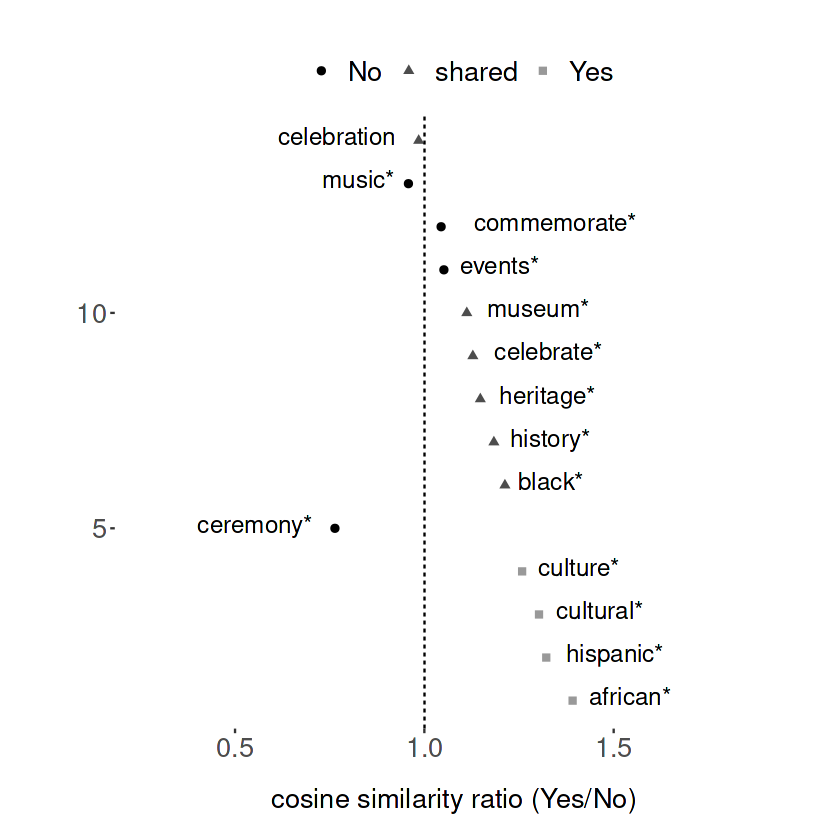

In [14]:
# nearest neighbor cosine similarity ratio
feats <- featnames(dfm(target_toks))

# compute ratio
set.seed(2021L)
target_nns_ratio <- get_nns_ratio(x = target_toks, 
                                 N = 10,
                                 groups = docvars(target_toks, 'AfterBLM'),
                                 numerator = "Yes",
                                 candidates = feats,
                                 pre_trained = glove_model,
                                 transform = TRUE,
                                 transform_matrix = local_transform,
                                 bootstrap = TRUE,
                                 num_bootstraps = 500,
                                 permute = TRUE,
                                 num_permutations = 500,
                                 verbose = FALSE)

plot_nns_ratio(x = target_nns_ratio, alpha = 0.02, horizontal = FALSE)

target_plot <- plot_nns_ratio(x = target_nns_ratio, alpha = 0.02, horizontal = FALSE)

# save our plot
ggsave("/kaggle/working/twitter_thesis_nns_AfterBLM_black.png", 
       plot = target_plot, 
       height=6, 
       width=8.5, 
       units="in", 
       dpi=700)

starting bootstraps 
done with bootstraps 
starting permutations 
done with permutations 


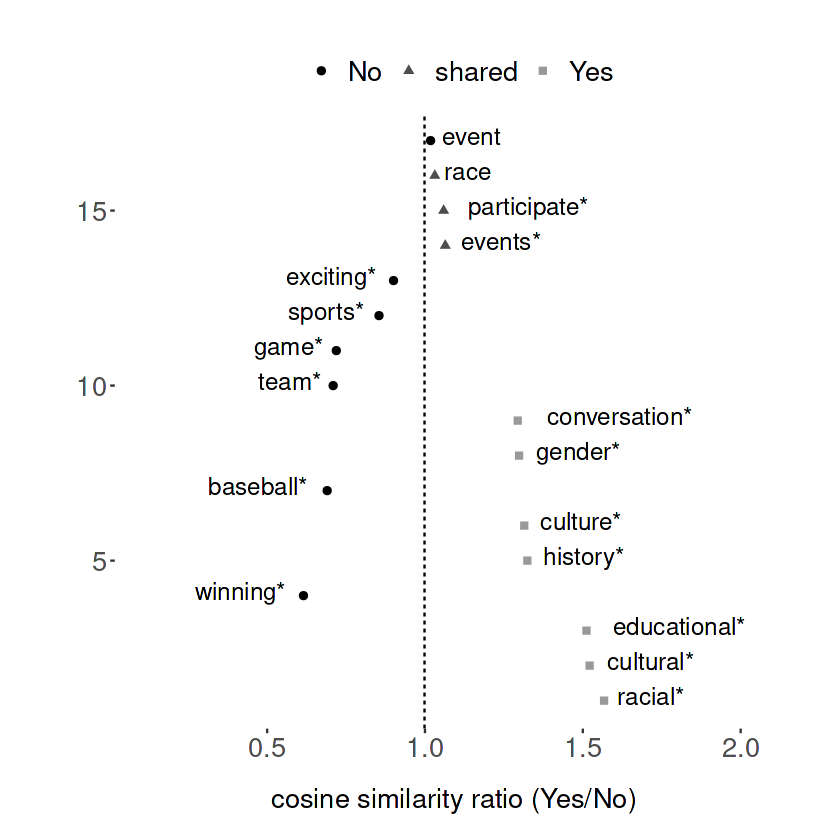

In [15]:
# nearest neighbor cosine similarity ratio
feats <- featnames(dfm(target_toks))

# compute ratio
set.seed(2021L)
target_nns_ratio <- get_nns_ratio(x = target_toks_race, 
                                 N = 10,
                                 groups = docvars(target_toks_race, 'AfterBLM'),
                                 numerator = "Yes",
                                 candidates = feats,
                                 pre_trained = glove_model,
                                 transform = TRUE,
                                 transform_matrix = local_transform,
                                 bootstrap = TRUE,
                                 num_bootstraps = 500,
                                 permute = TRUE,
                                 num_permutations = 500,
                                 verbose = FALSE)

plot_nns_ratio(x = target_nns_ratio, alpha = 0.02, horizontal = FALSE)

target_plot <- plot_nns_ratio(x = target_nns_ratio, alpha = 0.02, horizontal = FALSE)

# save our plot
ggsave("/kaggle/working/twitter_thesis_nns_AfterBLM_race.png", 
       plot = target_plot, 
       height=6, 
       width=8.5, 
       units="in", 
       dpi=700)